# ВАХ и деградация

In [1]:
import os
import re
import glob
from collections import defaultdict

import numpy as np
from scipy import interpolate, stats
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

# Настройки визуализации
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 100,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 10,
    "lines.linewidth": 1.5,
    "errorbar.capsize": 1.5,
    "image.cmap": "viridis",
    "axes.prop_cycle": cycler(color=plt.cm.plasma(np.linspace(0, 1, 11)))
})

SAVE_FIGS = False
FIG_DPI = 600

%matplotlib notebook


## 1. Зависимость ВАХ от энергии (Филипп)

### Загрузка данных

1. Названия файлов [ВАХ]:

`x v y deg z mA` — прикладываемое напряжение `x` В на энергии, соответсвующей углу монохроматора `y` градусов с током накопителя `z` мА.

2. Заголовки файлов [ВАХ]:

`Время (мс)` — абсолютное время, по нему проводится усреднение;

`Сигнал (В)` — значение напряжения с PIN-диода.

In [2]:
def angle2energy(angle: float) -> float:
    """Перевод угла (градусы) в энергию (кэВ)"""
    
    return 12.39841 / (2 * (5.341 / np.sqrt(3)) * np.sin(np.deg2rad(angle + 0.299)))


def load_cvc_grouped(skiprows: int = 1) -> dict:
    
    """Загрузка данных по маске с извлечением параметров из имени файла"""
    
    grouped_data = defaultdict(list)
    pattern = re.compile(
        r"(\d+[\.,]?\d*)\s*v\s*(\d+[\.,]?\d*)\s*deg\s*(\d+[\.,]?\d*)\s*mA\.txt"
    )

    for file_path in glob.glob("Филипп/* v * deg * mA.txt"): # извлечение из директории Филипп
        match = pattern.search(file_path)
        if not match:
            continue

        try:
            voltage = float(match.group(1).replace(",", "."))
            energy = angle2energy(float(match.group(2).replace(",", ".")))
            beam_current = float(match.group(3).replace(",", "."))

            data = np.loadtxt(file_path, skiprows=skiprows, delimiter=",")
            mean_val = np.mean(data[:, 1])
            error_val = stats.sem(data[:, 1]) # стандартная ошибка среднего

            # нормировка: напряжение / 300 кОм / ток накопителя
            grouped_data[energy].append(
                [mean_val/300/beam_current, error_val/300/beam_current, -voltage]
            )
        except Exception as e:
            print(f"[!] Ошибка при обработке файла {file_path}: {e}")

    return dict(sorted(grouped_data.items())) # сортировка по энергии


def build_interpolations(grouped_data: dict) -> dict:
    """Создание интерполяционных функций для каждого набора данных"""
    
    result = {}
    for energy, data_list in grouped_data.items():
        data_array = np.array(data_list)
        # сортировка по напряжению
        sort_idx = np.argsort(data_array[:, 2])
        voltages, currents, errors = (
            data_array[sort_idx, 2],
            data_array[sort_idx, 0],
            data_array[sort_idx, 1],
        )
        # интерполяционная функция; 
        # w-веса, k-степень полинома
        result[energy] = UnivariateSpline(voltages, currents, w = 1/errors, k=1)
    return result


In [3]:
grouped_CVC = load_cvc_grouped()

# проверка на адекваность загрузки данных (раскомментировать для отладки)

'''
for energy, data_list in grouped_CVC.items():
    print(f"Энергия {energy:.2f} кэВ")
    data_array = np.array(data_list)
    print(f"  Нормированый ток: {data_array[:, 0]} +/- {data_array[:, 1]} мА")
    print(f"  Напряжение: {data_array[:, 2]} В")
'''

'\nfor energy, data_list in grouped_CVC.items():\n    print(f"Энергия {energy:.2f} кэВ")\n    data_array = np.array(data_list)\n    print(f"  Нормированый ток: {data_array[:, 0]} +/- {data_array[:, 1]} мА")\n    print(f"  Напряжение: {data_array[:, 2]} В")\n'

### Интерполяция и отрисовка

Конкретно здесь интерполяция необязательна и просто "сглаживает" линию для визуализации.

<IPython.core.display.Javascript object>


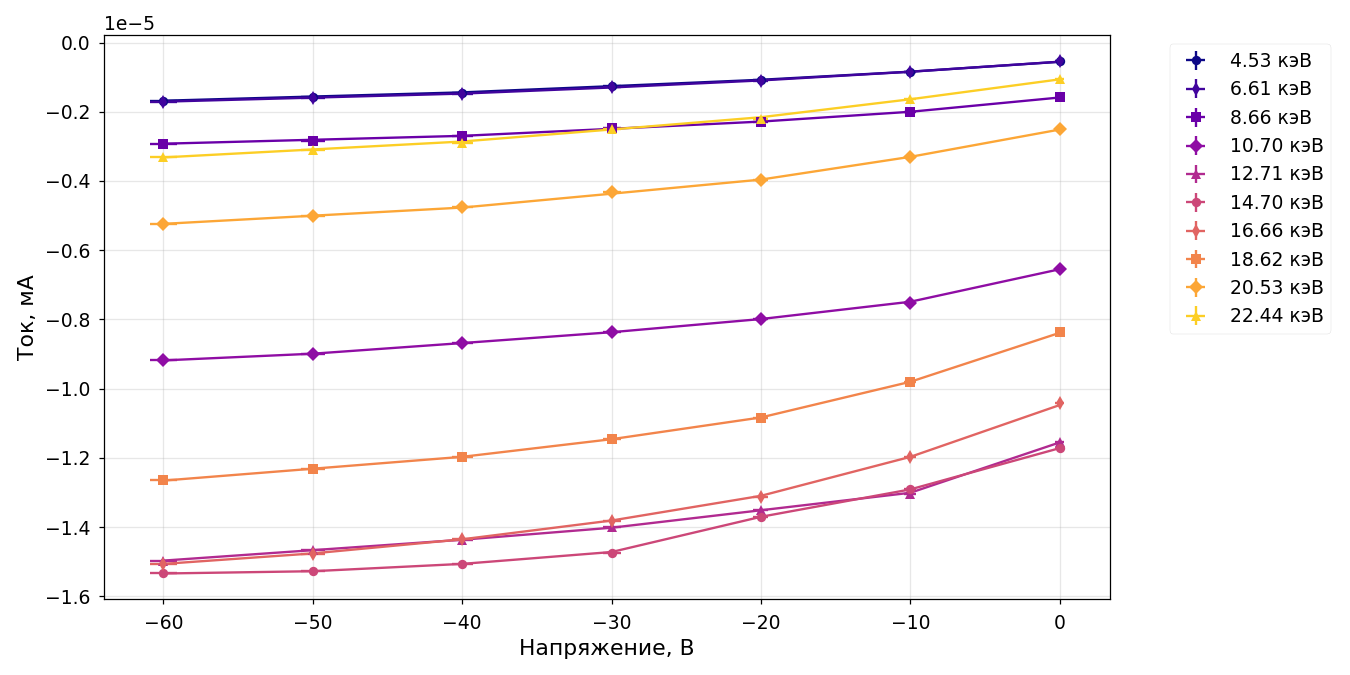

In [4]:
interpolation_functions = build_interpolations(grouped_CVC)

fig, ax = plt.subplots() 
markers = ["o", "d", "s", "D", "^"] * 3 # разные маркеры для различимости 

for i, (energy, data_list) in enumerate(grouped_CVC.items()):
    data_array = np.array(data_list)
    interp_func = interpolation_functions[energy]
    interp_voltages = np.linspace(data_array[:, 2].min(), data_array[:, 2].max(), 100)
    interp_currents = interp_func(interp_voltages)

    color = next(ax._get_lines.prop_cycler)['color']
    
    ax.plot(interp_voltages, interp_currents, '-', color=color)
    ax.errorbar(data_array[:, 2], data_array[:, 0],
                yerr=data_array[:, 1],
                xerr=0.01 * np.abs(data_array[:, 2]) + 0.3,
                fmt=markers[i % len(markers)], ms=6,
                color=color, label=f"{energy:.2f} кэВ")

ax.set_xlabel("Напряжение, В")
ax.set_ylabel("Ток, мА")
ax.grid(alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12) # легенда вне графика
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("CVC(E).png", dpi=FIG_DPI)
plt.show()

<IPython.core.display.Javascript object>


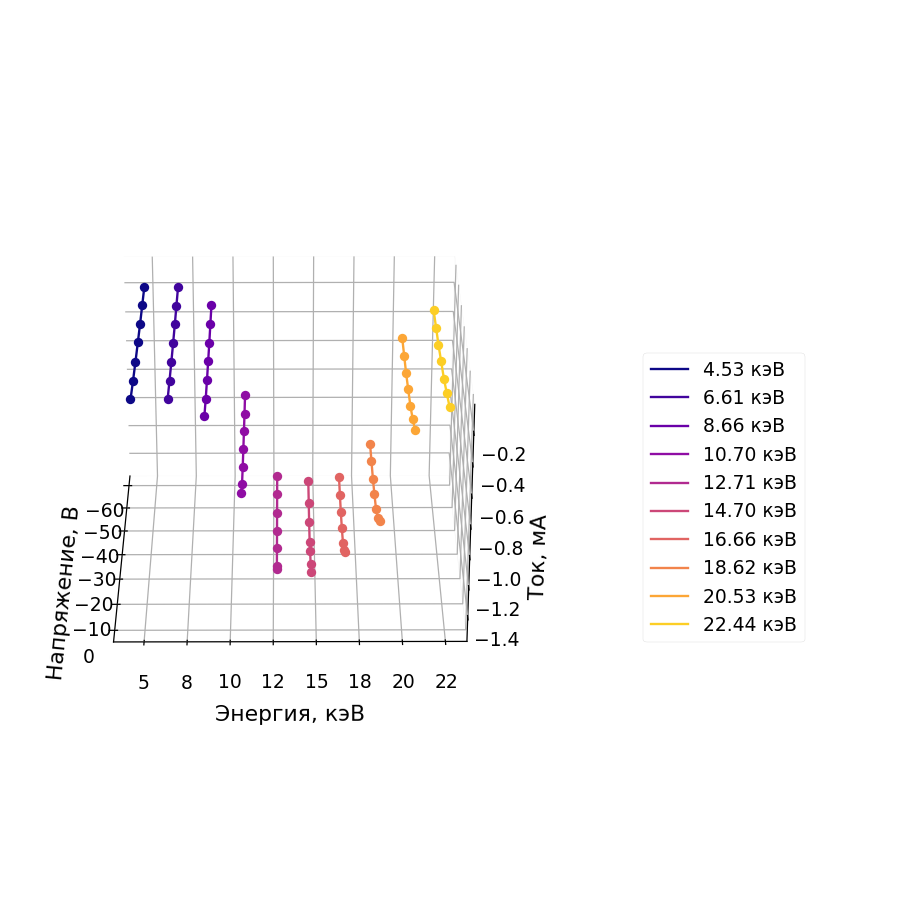

In [5]:
# 3d график (показался мне хорошим дополнением к
# предыдущему графику, позволяющий проследить зависимость от энергии)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.labelpad = 10  # отступы для подписи осей
ax.yaxis.labelpad = 10  
ax.zaxis.labelpad = 10  

ax.xaxis.pane.set_facecolor('white') # белый фон для сетки
ax.yaxis.pane.set_facecolor('white')
ax.zaxis.pane.set_facecolor('white')

for energy, interp_func in interpolation_functions.items():
    data_array = np.array(grouped_CVC[energy])
    interp_voltages = np.linspace(data_array[:, 2].min(), data_array[:, 2].max(), 100)
    interp_currents = interp_func(interp_voltages)
    energies = np.full_like(interp_voltages, energy)

    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(interp_voltages, energies, interp_currents, '-', color=color, label=f"{energy:.2f} кэВ")
    ax.plot(data_array[:, 2], np.full_like(data_array[:, 2], energy), data_array[:, 0], 'o', ms=6, color=color)

ax.set_xlabel('Напряжение, В')
ax.set_ylabel('Энергия, кэВ')
ax.set_zlabel('Ток, мА')

# более аккуратный вид делений
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.legend(bbox_to_anchor=(1.5, 0.7), loc='upper right', fontsize=12)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("3d_line_plot.png", dpi=FIG_DPI)
plt.show()


## 2. Деградация ВАХ (Ира)

### Загрузка данных

- Названия файлов [ВАХ]:

`n x v y deg` — `n`е измерение с прикладываемым напряжением `x` В

- 1: первое измерение на энергии 9 кэВ (0 минут)
- 2: второе измерение на энергии 9 кэВ (30 минут)
- 3: третье измерение на энергии 9 кэВ (60 минут)
- 4: измерение после БП (90 минут)

In [6]:
def load_cvc_data(pattern: str, skiprows: int = 1) -> dict:
    """Универсальная загрузка CVC данных по шаблону"""
    
    grouped_data = defaultdict(list)
    compiled_pattern = re.compile(pattern)
    search_pattern = os.path.join("Ира/* v * deg.txt")

    for file_path in glob.glob(search_pattern):
        filename = os.path.basename(file_path)
        match = compiled_pattern.search(filename)
        if not match:
            continue
        try:
            number = int(match.group(1)) # номер ВАХ
            voltage = float(match.group(2).replace(',', '.'))
            data = np.loadtxt(file_path, skiprows=skiprows, delimiter='\t')
            mean_val = np.mean(data[:, 1])
            error_val = stats.sem(data[:, 1]) # стандартная ошибка среднего
            grouped_data[number].append([mean_val/300, error_val/300, -voltage])
        except Exception as e:
            print(f"[!] Ошибка при обработке {file_path}: {e}")

    result = {}
    for number, values in grouped_data.items():
        arr = np.array(values)
        # сортировка по напряжениям
        arr = arr[np.argsort(arr[:, 2])]
        result[number] = arr
    return result


In [7]:
degr_CVC = load_cvc_data(r'(\d)\s(\d+[\.,]?\d*)\sv\s(\d+[\.,]?\d*)\s*deg\.txt')
dark_CVC = load_cvc_data(r'(\d)d\s(\d+[\.,]?\d*)\sv\s(\d+[\.,]?\d*)\s*deg\.txt')

# проверка на адекваность загрузки данных (раскомментировать для отладки)
'''
for number in degr_CVC:
    data = degr_CVC[number]
    print(f"Номер {number}: {len(data)} точек")
    print(f"  Ток: {data[:, 0]} +/- {data[:, 1]} мА")
    print(f"  Напряжение: {data[:, 2]}")
print("_____________________________________________________")
for number in dark_CVC:
    data = dark_CVC[number]
    print(f"Номер {number}: {len(data)} точек")
    print(f"  Ток: {data[:, 0]} +/- {data[:, 1]} мА")
    print(f"  Напряжение: {data[:, 2]}")
'''

'\nfor number in degr_CVC:\n    data = degr_CVC[number]\n    print(f"Номер {number}: {len(data)} точек")\n    print(f"  Ток: {data[:, 0]} +/- {data[:, 1]} мА")\n    print(f"  Напряжение: {data[:, 2]}")\nprint("_____________________________________________________")\nfor number in dark_CVC:\n    data = dark_CVC[number]\n    print(f"Номер {number}: {len(data)} точек")\n    print(f"  Ток: {data[:, 0]} +/- {data[:, 1]} мА")\n    print(f"  Напряжение: {data[:, 2]}")\n'

<IPython.core.display.Javascript object>


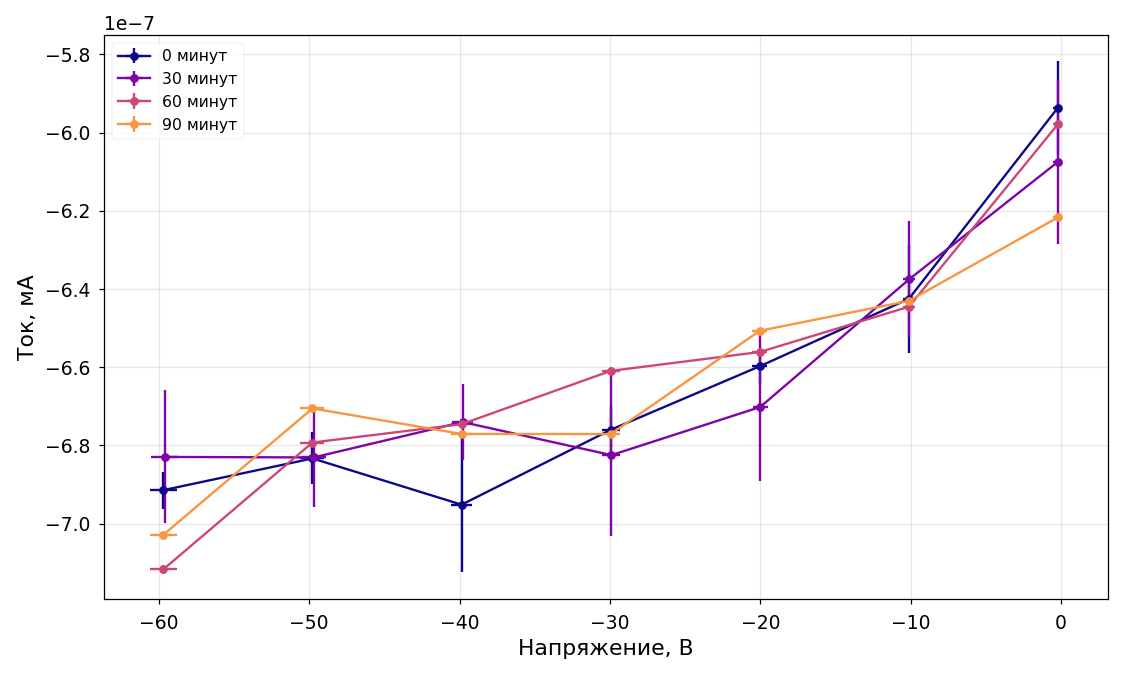

In [8]:
beam_currents = [7.766, 7.312, 6.415,5.186*1.68] 
# в последнем случае была другая щель 
#(поправочный коэффициент, природа которого не до конца ясна)

corrected_CVC = {}

for number in degr_CVC:
    if number not in dark_CVC:
        continue

    degr_data = degr_CVC[number]
    dark_data = dark_CVC[number]

    common_voltages = np.linspace(np.min([min(degr_data[:,2]),min(dark_data[:,2])])-0.5,
                                  np.max([max(degr_data[:,2]),max(dark_data[:,2])])+0.5, 7)

    degr_interp = UnivariateSpline(degr_data[:, 2], savgol_filter(degr_data[:, 0], 3, 1, mode='interp'),
                                   w=beam_currents[number-1]/degr_data[:, 1], k=3, s=0)
    dark_interp = UnivariateSpline(dark_data[:, 2], savgol_filter(dark_data[:, 0], 3, 1, mode='interp'),
                                   w=beam_currents[number-1]/dark_data[:, 1], k=3, s=0)

    std_degr = interpolate.interp1d(degr_data[:, 2], degr_data[:, 1], fill_value='extrapolate', kind='cubic')
    std_dark = interpolate.interp1d(dark_data[:, 2], dark_data[:, 1], fill_value='extrapolate', kind='cubic')

    degr_current = degr_interp(common_voltages)
    dark_current = dark_interp(common_voltages)
    std_total = np.sqrt(std_degr(common_voltages)**2+std_dark(common_voltages)**2)/beam_currents[number-1]

    corrected_current = (degr_current-dark_current)/beam_currents[number-1]
    corrected_CVC[number] = np.column_stack((corrected_current, common_voltages, std_total))

plt.rcParams.update({"axes.prop_cycle": cycler(color=plt.cm.plasma(np.linspace(0, 1, 5)))})

plt.figure(figsize=(10, 6))
for number, arr in corrected_CVC.items():
    plt.errorbar(arr[:, 1], arr[:, 0],
                 yerr=arr[:, 2], xerr=0.01*np.abs(arr[:, 1])+0.3,
                 fmt='-o', label=f'{(number-1)*30} минут')

plt.xlabel("Напряжение, В")
plt.ylabel("Ток, мА")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("CVC_degradation.png", dpi=FIG_DPI)
plt.show()


### Деградация ВАХ. Интерполяция 

Для того, чтобы найти ВАХ чистого сигнала, нужно вычесть значения темнового тока. Поскольку эти измерения были сняты в разных точках по напряжению, вычесть поточечно (как сделала Ира) их будет неправильно, и необходимо интерполировать значения.

Однако здесь кроется ряд проблем, поспольку интерполяция чувствительна к выбросам. Во избежание этого перед интерполяцией производится фильтрация данных методом Савицкого-Голея (метод основан на аппроксимации окрестности каждого измерения степенным полиномом). Ячейка ниже показывает поэтапно данный процесс, выше приведен итоговый график.

<IPython.core.display.Javascript object>


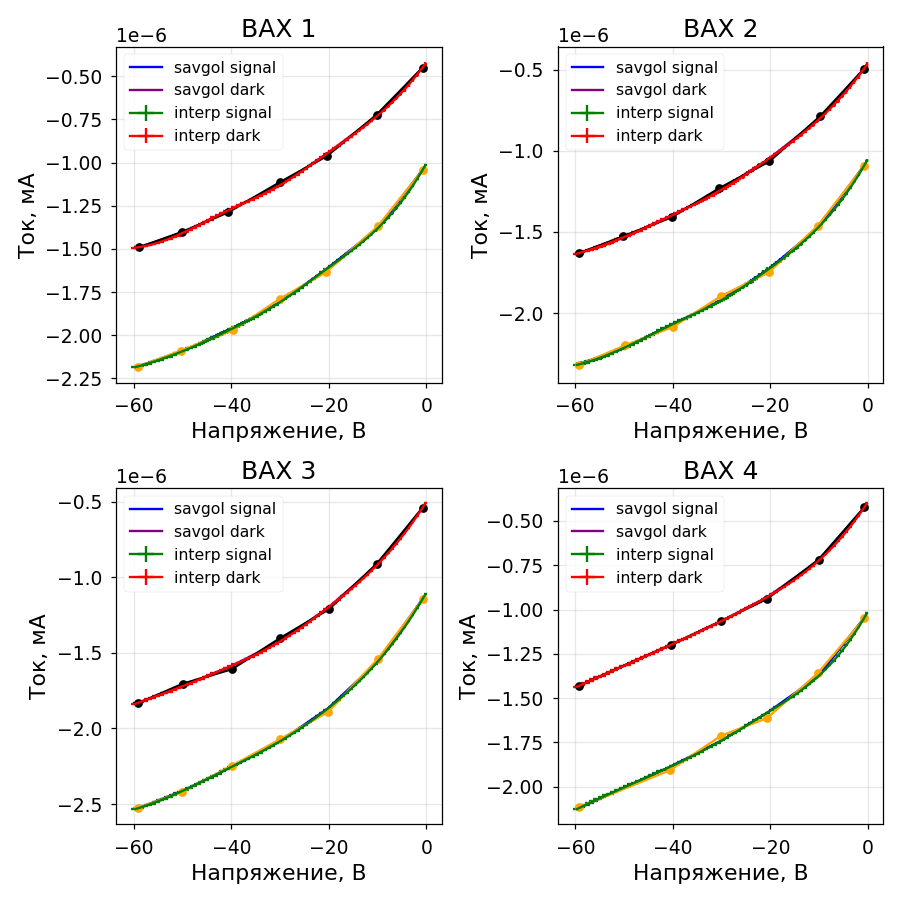

In [9]:
# Отладочный график

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
plt.rcParams.update({"axes.prop_cycle": cycler(color=plt.cm.plasma(np.linspace(0, 1, 10)))})
for number in degr_CVC:
    if number not in dark_CVC:
        continue

    degr_data = degr_CVC[number]
    dark_data = dark_CVC[number]
    common_voltages = np.linspace(np.min([min(degr_data[:,2]),min(dark_data[:,2])])-0.5,
                                  np.max([max(degr_data[:,2]),max(dark_data[:,2])])+0.5, 71)
    
    degr_current_filtered = savgol_filter(degr_data[:, 0], 5, 3, mode='interp')
    dark_current_filtered = savgol_filter(dark_data[:, 0], 5, 3, mode='interp')
    
    degr_interp = UnivariateSpline(degr_data[:, 2], degr_current_filtered,
                                   w=beam_currents[number-1]/degr_data[:, 1], k=3, s=0)
    dark_interp = UnivariateSpline(dark_data[:, 2], dark_current_filtered,
                                   w=beam_currents[number-1]/dark_data[:, 1], k=3, s=0)

    std_degr = interpolate.interp1d(degr_data[:, 2], degr_data[:, 1], fill_value='extrapolate', kind='cubic') #интерполяция для ошибок
    std_dark = interpolate.interp1d(dark_data[:, 2], dark_data[:, 1], fill_value='extrapolate', kind='cubic')

    degr_current = degr_interp(common_voltages)
    dark_current = dark_interp(common_voltages)

    std_total = np.sqrt(std_degr(common_voltages)**2 + std_dark(common_voltages)**2) / beam_currents[number-1]

    axes[number-1].errorbar(degr_data[:, 2], degr_data[:, 0]/beam_currents[number-1],
                     xerr=0.01*np.abs(degr_data[:, 2])+0.3, yerr=degr_data[:,1]/beam_currents[number-1],
                            color='orange', marker='o')
    axes[number-1].errorbar(common_voltages, degr_current/beam_currents[number-1],xerr=0.01*np.abs(common_voltages)+0.3,
                            yerr=np.abs(std_degr(common_voltages)/ beam_currents[number-1]),
                            color='green', label='interp signal')
    axes[number-1].plot(degr_data[:,2], degr_current_filtered/beam_currents[number-1],
                        color='blue', label='savgol signal')

    
    # Исходные dark данные
    dark_data = dark_CVC[number]
    axes[number-1].errorbar(dark_data[:, 2], dark_data[:, 0]/beam_currents[number-1], 
                     xerr=0.01*np.abs(dark_data[:, 2])+0.3, yerr=dark_data[:,1]/beam_currents[number-1],
                            color='black', marker='o')
    axes[number-1].errorbar(common_voltages, dark_current/beam_currents[number-1],xerr=0.01*np.abs(common_voltages)+0.3,
                            yerr=np.abs(std_dark(common_voltages)/ beam_currents[number-1]),
                            color='red', label='interp dark')
    axes[number-1].plot(dark_data[:,2], dark_current_filtered/beam_currents[number-1],
                        color='purple', label='savgol dark')
    
    axes[number-1].set_xlabel("Напряжение, В")
    axes[number-1].set_ylabel("Ток, мА")
    axes[number-1].set_title(f"ВАХ {number}")
    axes[number-1].grid(True, alpha=0.3)
    axes[number-1].legend()

#SAVE_FIGS=True    
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("CVC_degradation_manually.png", dpi=FIG_DPI)
plt.show()

## Доза излучения

### Спектр поворотного магнита: $\frac{ph/sec}{(mrad)^2 (0.1 \% b.w.)}=1,327\cdot10^{13}E^2[\text{ГэВ}]I[\text{А}]x^2K^2_{2/3}(x/2)$;

### $x=\varepsilon/\varepsilon_c$

`E` = 4,5 ГэВ - энергия накопителя, `I` - ток накопителя, $\varepsilon$= 9 кэВ - энергия облучения, $\varepsilon_c$= 5,86 кэВ - критическая энергия, $K_{2/3}$ - функция Макдональда

C:\Users\nmurz\AppData\Local\Temp\ipykernel_24948\4135085726.py:14: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


<IPython.core.display.Javascript object>


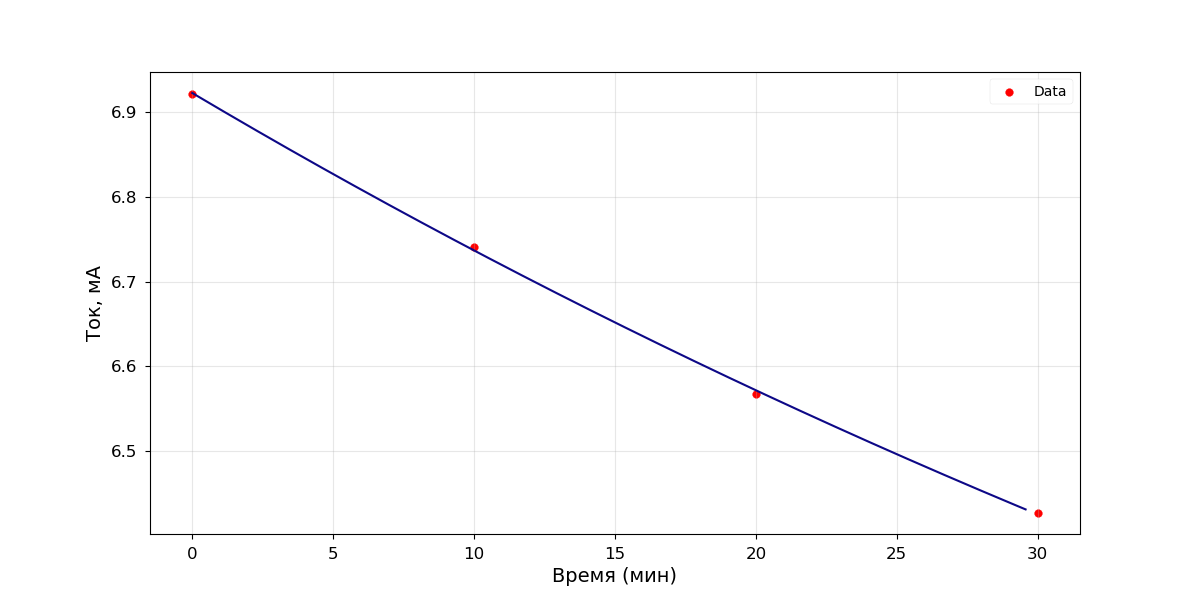

In [85]:
from scipy.special import kv
from scipy.integrate import simpson
from scipy.optimize import curve_fit

def F(I, energy):
    x = energy / 5.86
    return 4 * np.pi * 1.327e13 * 4.5**2 * (I / 1000) * x**2 * kv(2/3, x/2)**2

curr = np.loadtxt("Радиационная устойчивость( 30 min) 12.7 deg.txt")
curr[:, 0] = (curr[:, 0] - curr[0, 0]) / 60000  # Конвертация из мс в минуты
curr[:, 1] /= 300000  # Ток в А

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

B_curr2 = np.loadtxt("dosa2.txt")
popt, pcov = curve_fit(func, B_curr2[:, 1], B_curr2[:, 0])
beam2 = func(curr[:, 0], *popt)  # Ток пучка

E_range = np.linspace(2, 31, 100)

G_vals = 4 * np.pi * 1.327e13 * 4.5**2 / 1000 * (E_range/5.86)**2 * kv(2/3, E_range/(2*5.86))**2
integral_val = simpson(G_vals, E_range, dx=E_range[1]-E_range[0]) # умножить на кривые пропускания
flux = beam2 * integral_val 
# проинтегрировать по времени

# для отладки
plt.rcParams.update({"axes.prop_cycle": cycler(color=plt.cm.plasma(np.linspace(0, 1, 4)))})
plt.figure()
#plt.plot(curr[:, 0], flux, label='Flux')
plt.plot(curr[:, 0], beam2, '-')
plt.scatter(B_curr2[:, 1], B_curr2[:, 0], color='red', label='Data')
plt.grid(alpha=0.3)
plt.xlabel("Время (мин)")
plt.ylabel("Ток, мА")
plt.legend()
plt.show()